# Test Project: Beer Reviews Analysis and Recommendation

###  Recommend beers based on the data

Data: 1.5M beer reviews from beer advocate. (https://s3.amazonaws.com/demo-datasets/beer_reviews.tar.gz)


In [1]:
%matplotlib inline

### Import packages Numpy, Scikit Learn and Pandas

In [2]:
import numpy as np
import sklearn
import pandas as pd

Read in the "csv" file with reviews into a pandas "data frame". Pandas has this nice reader that can read a bunch of file formats and store the data in a "data frame"

In [3]:
beerData = pd.read_csv('/Users/phani/Downloads/beer_reviews/beer_reviews.csv', delimiter=",", encoding='utf-8')
# download the revievs csv form the link above. Alternatively, use 'urlopen' and rebuild this command 
#to read the csv file after unzipping the response 

In [4]:
#for i in range(len(beer_data.columns)):
#    print("Column",i, ": ", beer_data.columns[i])
#
#print ("*************************")
#print("Columns with Null Values")
#for column in beer_data.columns:
#    count = len(beer_data.loc[pd.isnull(beer_data[column])])
#    if count > 0 :
#       print ("Column Name: ", column, " Null Values: ", count)

#### Q2. Recommend beers based on the data - Approach 1

A simple ordering of data based on review_overall should give us a list with beers and their corresponding ranking in the list. 

#### Preprocessing
Number of reviews are not same for all beers. So, we will calculate the sample mean from the number of reviews we gathered for a beer to assign one overall_review for each beer. However, some beers have only one review where as others have more than one reviews. Hence, we need to clean up the data to include only those beers where we can calculate the mean within a certain margin of error. 

Data Cleaning: The statistics way to chose the threshold number of reviews (min number of samples) is to compute the minimum number of required reviews for a beer to predict the mean with 95% confidence interval. 

We use this formula: ($\frac{\sigma^2 * Z^2}{m^2}$), where $\sigma$ is the standard deviation of the sample, Z-score for a confidence interval of 95% is 1.96 and m is the allowed margin of error. 

In [5]:
# define a new dataframe with four attributes
samplesDF = beerData[["beer_beerid","beer_name","review_overall", "review_profilename"]]

# drop duplicate reviews for the same beer
samplesDF = samplesDF.drop_duplicates(["beer_beerid","review_profilename"])

# set indices for determining levels
samplesDF = samplesDF.set_index(["beer_beerid","beer_name"])

# Calculate nSamples, sampleMeans, sampleStdDev
nSamples = samplesDF.groupby(level=0).count().to_dict()
sampleMeans = samplesDF.groupby(level=0).mean().to_dict()
sampleStdDev = samplesDF.groupby(level=0).std()


# Define Margin of Error and Z-score for 95% confidence interval
mError = 0.1
zScore = 1.96

# filter out sampleMeans with less number of reviews than minimum required
# to achieve 95% confidence interval, sort sampleMeans and rank beer_ids 
# from the sorted sampleMeans
# reject samples with std dev = 0.0

sampleMeansTemp = {}
for key in nSamples.keys(): 
    if key == "review_overall": # we are only interested in overall_review
        for beerID in nSamples[key].keys(): # get the values - beer_beerid and overall review
            if sampleStdDev[key][beerID] > 0:
                nSamplesRequired = (sampleStdDev[key][beerID] * zScore/mError)**2
            if nSamples[key][beerID] > nSamplesRequired:
                sampleMeansTemp[beerID] =  sampleMeans[key][beerID]

# redefine sampleMeans by sorted overall_reviews 
sampleMeans = sorted(sampleMeansTemp.items(), key=lambda x: x[1] , reverse=True)

# Filter out the beerIDs that are not included in sampleMeans list
# make a new dataframe
# appending rows to make a new data frame takes a lot of time. So we will take this approach. 
#Take the original data frame and drop the rows by comparing beerIDs

reviewBeerIDs = [beerKey[0] for beerKey in sampleMeans]
# drop the duplicate beerIDs 
newBeerDF = beerData.drop_duplicates(["beer_beerid"])
beerIDsAll = newBeerDF.beer_beerid.tolist()

# list the iDs that we need to discard
discardBeerIDs = [beerID for beerID in beerIDsAll if beerID not in reviewBeerIDs]
newBeerDF = newBeerDF.set_index(["beer_beerid"])
newBeerDF = newBeerDF.drop(discardBeerIDs)

#drop other labels and leave only few for visualization
newBeerDF = newBeerDF.drop(['brewery_id','review_time', 'review_overall','review_aroma','review_taste',
                    'review_palate','review_profilename','beer_abv','review_appearance'], axis=1)

# Create a column review_overall with values from sampleMeans
review_overall = []
for beerIndex in newBeerDF.index.tolist():
    for keyIndex in range(len(sampleMeans)):
        if sampleMeans[keyIndex][0] == beerIndex:
            review_overall.append(sampleMeans[keyIndex][1])

# add the column review_overall values from sampleMeans list
newBeerDF['review_overall'] = review_overall

# sort the dataframe by overall reviews and print the top ten beers in the list
newBeerDF = newBeerDF.sort_values(by='review_overall', ascending=False)
newBeerDF.head(10)

,brewery_name,beer_style,beer_name,review_overall
beer_beerid,,,,
63649,Peg's Cantina & Brewpub / Cycle Brewing,American Double / Imperial Stout,Rare D.O.S.,4.848485
44910,De Struise Brouwers,Lambic - Unblended,Dirty Horse,4.820513
8626,Southampton Publick House,Berliner Weissbier,Southampton Berliner Weisse,4.768293
68548,Brouwerij Drie Fonteinen,Gueuze,Armand'4 Oude Geuze Lente (Spring),4.730769
70356,Brouwerij Drie Fonteinen,Gueuze,Armand'4 Oude Geuze Zomer (Summer),4.644444
56082,Kern River Brewing Company,American Double / Imperial IPA,Citra DIPA,4.628049
36316,Brasserie Cantillon,Lambic - Fruit,Cantillon Blåbær Lambik,4.625806
41928,Russian River Brewing Company,American Wild Ale,Deviation - Bottleworks 9th Anniversary,4.620536
16814,The Alchemist,American Double / Imperial IPA,Heady Topper,4.618510


#### Q2. Recommend beers based on the data - Build a content-based recommendation system

In a content based recommendation system, we will calculate user preferences based on beer features and overall_review for a beer. We can then predict the overall rating for any beer given the features of a beer by an average user. 

Data Matrix: Lets assume that individual ratings (appearance,aroma, palate, taste) correlate with beer features and hence correlate with overall rating by reviewers/users. DataMatrix contains the overall review for a beer calculated as the sampleMean of the overall_review by all reviewers. 

Features Matrix: Features matrix contains four features (appearance,aroma, palate, taste) rated by different users. We assume that the rating is proportional to their tastes and correspond to the features of a given beer. (We will not use ABV% here as one of the feature. It has many undefined values that could shrink our feature set.)

Data Cleaning: We collect user info based on review_profilename. Hence, some data points with missing "review_profilename" are dropped from the data matrix. We will use the reduced dataset from the above approach that satisfy minimum number of samples required to predict population means with 95% confidence level given a sample stdDev and margin of error. Here we will use sampleMeans for each attribute: aroma, palette, appearance and taste and the overall_review

Finally, we use linear regression to calculate the parameters that correlate features with overall rating. 

In [6]:
# Feature Matrix
featureDF = beerData[["beer_beerid", "review_profilename",'review_appearance','review_aroma', 
                      'review_palate','review_taste','review_overall']]
featureDF = featureDF.drop_duplicates(["beer_beerid","review_profilename"])
featureDF = featureDF.set_index("beer_beerid")
featureDF = featureDF.drop(discardBeerIDs)
featureDF = featureDF.reset_index()

# Make lists that match data matrix indices
beerIDList = sorted(featureDF.beer_beerid.unique())
profileList = featureDF.review_profilename.unique()

# We are interested in beer features. So we index the data frame using ID and profilename
# and calculate sample means of all features
featureDF = featureDF.set_index(["beer_beerid","review_profilename"])

# features sampleMeans
featuresDict = featureDF.groupby(level=0).mean().to_dict()
sampleMeans = featuresDict['review_overall']
appearanceSampleMeans = featuresDict['review_appearance']
aromaSampleMeans = featuresDict['review_aroma']
palateSampleMeans = featuresDict['review_palate']
tasteSampleMeans = featuresDict['review_taste']

# Define dataMatrix
dataMatrix = np.zeros(len(beerIDList*2)).reshape(len(beerIDList),2)

for beerIndex in range(len(beerIDList)):
        for key in sampleMeans.keys():
            if key == beerIDList[beerIndex]:
                dataMatrix[beerIndex][1] = sampleMeans[key]
                
# Define featureMatrix
featureMatrix = np.zeros(len(beerIDList*5)).reshape(len(beerIDList),5)
featuresMeansDicts = [appearanceSampleMeans,aromaSampleMeans,
                      palateSampleMeans,tasteSampleMeans]

for beerIndex in range(len(beerIDList)):
    featureMatrix[beerIndex][0] = beerIDList[beerIndex]
    dataMatrix[beerIndex][0] = beerIDList[beerIndex]
    
featureIndex = 1 # feature index in feature Matrix
for featureDict in featuresMeansDicts:
    for beerIndex in range(len(beerIDList)):
        for key in featureDict.keys():
            if key == beerIDList[beerIndex]:
                featureMatrix[beerIndex][featureIndex] = featureDict[key]
    featureIndex += 1


2529
2529


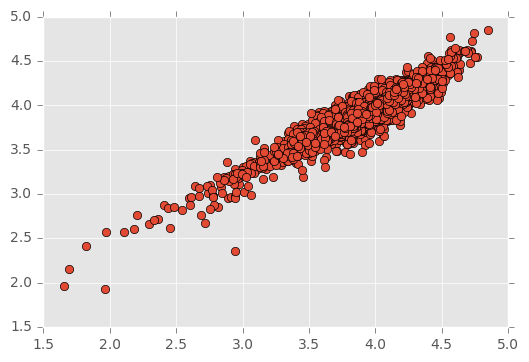

In [7]:
print (featureMatrix.shape[0])
print (dataMatrix.shape[0])

X = np.array([featureMatrix[i][1:] for i in range(featureMatrix.shape[0])if dataMatrix[i][1] > 0])
y = np.array([dataMatrix[i][1] for i in range(dataMatrix.shape[0])if dataMatrix[i][1] > 0])

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
#print(X)
xT = X.T
#print(xT)
#print(xT.shape)
#print(y.shape)
plt.plot(xT[3],y, 'o');

Weight coefficients:  [ 0.02695863 -0.41112331  0.04256156  1.09947967]
y-axis intercept:  0.934661669826
0.893419231624
0.87272987335
Lasso Regression (L1 penalty)
alpha = : 100
0.0
-0.00173534378159
alpha = : 10
0.0
-0.00173534378159
alpha = : 1
0.0
-0.00173534378159
alpha = : 0.01
0.864711258967
0.851765984844
Ridge Regression (L2 penalty)
alpha = : 100
0.832470032708
0.820076664804
alpha = : 10
0.876442836824
0.857522867216
alpha = : 1
0.892383663773
0.871684255669
alpha = : 0.01
0.893419068281
0.872728823819


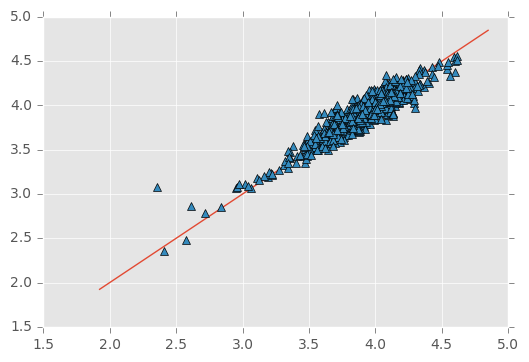

In [9]:
import sklearn 
from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7, random_state=1236)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(train_X, train_y)
print('Weight coefficients: ', regressor.coef_)
print('y-axis intercept: ', regressor.intercept_)
print(regressor.score(train_X,train_y))
print(regressor.score(test_X,test_y))

y_pred_train = regressor.predict(train_X)
y_pred_test = regressor.predict(test_X)

import matplotlib.pyplot as plt

plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.plot(test_y, y_pred_test, '^', label="test-prediction")

print ("Lasso Regression (L1 penalty)")
from sklearn.linear_model import Lasso
lasso_models = {}
for alpha in [100, 10, 1, .01]:
    lasso = Lasso(alpha=alpha).fit(train_X, train_y)
    print("alpha = :", alpha)
    print(lasso.score(train_X, train_y))
    print(lasso.score(test_X, test_y))
    lasso_models[alpha] = lasso

print ("Ridge Regression (L2 penalty)")
from sklearn.linear_model import Ridge
ridge_models = {}
for alpha in [100, 10, 1, .01]:
    ridge = Ridge(alpha=alpha).fit(train_X, train_y)
    print("alpha = :", alpha)
    print(ridge.score(train_X, train_y))
    print(ridge.score(test_X, test_y))
    ridge_models[alpha] = ridge






In [10]:
from sklearn.neighbors import KNeighborsRegressor
for i in range(1,5):
    kneighbor_regression = KNeighborsRegressor(n_neighbors=i)
    kneighbor_regression.fit(train_X, train_y)
    print ("No of Neighbors: ", i)
    print(kneighbor_regression.score(train_X, train_y))
    print(kneighbor_regression.score(test_X, test_y))

No of Neighbors:  1
1.0
0.761589254418
No of Neighbors:  2
0.949149796856
0.819922141559
No of Neighbors:  3
0.929539816216
0.83824992686
No of Neighbors:  4
0.920039733351
0.847798379782


#### Build a content-based recommendation system for each user

For a reviewer, we will recommend beers that he might like based on the data from his own ratings of other beers and sampleMeans of features for all beers.

Data Matrix: DataMatrix contains the overall_review for all beers separated by each reviewer along columns. (Difference between this and above is that in the above approach, sampleMeans of overall reviews are listed in dataMatrix) 

Features Matrix: Features matrix is same as above

Finally, we use linear regression to calculate the parameters for each user that correlate features with overall rating. 

In [11]:
# Data Matrix
dataDF = beerData[["beer_beerid","review_overall", "review_profilename"]]

# drop duplicate reviews for the same beer
dataDF = dataDF.drop_duplicates(["beer_beerid","review_profilename"])

# set indices for determining levels
dataDF = dataDF.set_index("beer_beerid")

# drop the rows with less number of reviews than required samples
# Refer to diff variable from above
dataDF = dataDF.drop(discardBeerIDs)

# Make a numpy 2D array with beerIDs on one axis 
# and profilenames on the other axis
dataDF = dataDF.reset_index()
beerIDList = sorted(dataDF.beer_beerid.unique())
profileList = dataDF.review_profilename.unique()

#************************************
# Building an actual data matrix with all beers and review_profiles is time consuming
# The code below shows the implementation and test for 2 beers and validate the approach.

# Define Data Matrix
dataMatrix = np.zeros(len(beerIDList) * len(profileList)).reshape(len(beerIDList),len(profileList))

# Reindex to use access dataframe using two indices of numpy array
dataDF = dataDF.set_index(["beer_beerid","review_profilename"])

for beerID in range(2):
    for profile in range(len(profileList)):
        try:
            rating = dataDF.loc[(beerIDList[beerID],profileList[profile]),"review_overall"]
            dataMatrix[beerID][profile] = rating
            #print(profile, beerID, rating)
        except KeyError:
            pass
    
            
#print (len([dataMatrix[0][i] for i in range(len(dataMatrix[0])) if dataMatrix[0][i] > 0]))

#### Calculate the parameterMatrix based on featureMatrix and subsets of dataMatrix

In [12]:
# Take first ten profile names and build a dataMatrix for 10 profiles
profiles = profileList[:10]

# Define Data Matrix
subDataMatrix = np.zeros(len(beerIDList) * (len(profiles) + 1)).reshape(len(beerIDList),len(profiles)+1)

# Reindex to use access dataframe using two indices of numpy array
#dataDF = dataDF.set_index(["beer_beerid","review_profilename"])

for beerIndex in range(len(beerIDList)):
    subDataMatrix[beerIndex][0] = beerIDList[beerIndex]
    
for beerID in range(len(beerIDList)):
    for profile in range(len(profiles)):
        try:
            rating = dataDF.loc[(beerIDList[beerID],profiles[profile]),"review_overall"]
            subDataMatrix[beerID][profile+1] = rating
        except KeyError:
            pass

print (np.shape(subDataMatrix))
print (np.shape(featureMatrix))


(2529, 11)
(2529, 5)
